# Import libraries

In [1]:
%pip install -r requirements.txt
# %pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import standard libraries
import re
import string
import datetime as dt

# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Import NLP libraries
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import emoji
from textblob import TextBlob

# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Set random seed for reproducibility
seed = 0
np.random.seed(seed)

# Suppress chained assignment warning
pd.options.mode.chained_assignment = None

2024-11-05 13:44:09.834646: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 13:44:09.908450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 13:44:09.976012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730789050.034640   48136 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730789050.051704   48136 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 13:44:10.185228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

# Load dataset

In [4]:
df = pd.read_csv('../app_review.csv')

In [5]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,9b1e9713-f88e-4547-be41-b87d840089cc,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Great game, and I enjoy playing it, but now it...",2,1,2.6.0,2024-10-29 13:45:27,NaN,NaN,2.6.0
1,057d6353-31e5-4cf1-9a6d-a9947631bece,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,For me the game itself is very well-made in te...,5,0,2.6.0,2024-10-29 13:38:53,NaN,NaN,2.6.0
2,a78877c7-5ea4-4689-a72f-e8ead2ac8c3a,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This game is as marvelous as Genshin Impact! T...,5,5,2.6.0,2024-10-29 13:31:21,NaN,NaN,2.6.0
3,59a0b3c8-1b2a-4877-84fb-c76b79b5a924,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Not fold friendly. Cant aim at enemies at the ...,3,0,2.6.0,2024-10-29 12:48:45,NaN,NaN,2.6.0
4,d135b884-683a-4daa-9b2e-d8ef29c69df4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Other than storage this game is amazing I love...,5,0,NaN,2024-10-29 11:12:16,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37018 entries, 0 to 37017
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              37018 non-null  object
 1   userName              37018 non-null  object
 2   userImage             37018 non-null  object
 3   content               37015 non-null  object
 4   score                 37018 non-null  int64 
 5   thumbsUpCount         37018 non-null  int64 
 6   reviewCreatedVersion  26993 non-null  object
 7   at                    37018 non-null  object
 8   replyContent          1191 non-null   object
 9   repliedAt             1191 non-null   object
 10  appVersion            26993 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.1+ MB


In [7]:
df.shape

(37018, 11)

In [8]:
# clean_df[['content','sentiment']].head()

In [9]:
# clean_df.to_csv('clean_app_review.csv', index=False)

# Text Preprocessing

## Cleaning data

In [10]:
clean_df = df.dropna(subset=['content'])
clean_df = clean_df.drop_duplicates(subset=['content'])

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33428 entries, 0 to 37017
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              33428 non-null  object
 1   userName              33428 non-null  object
 2   userImage             33428 non-null  object
 3   content               33428 non-null  object
 4   score                 33428 non-null  int64 
 5   thumbsUpCount         33428 non-null  int64 
 6   reviewCreatedVersion  24382 non-null  object
 7   at                    33428 non-null  object
 8   replyContent          1178 non-null   object
 9   repliedAt             1178 non-null   object
 10  appVersion            24382 non-null  object
dtypes: int64(2), object(9)
memory usage: 3.1+ MB


In [11]:
clean_df.shape

(33428, 11)

In [12]:
# Function to clean text
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Remove White Space
    text = text.strip()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, wordnet.VERB) for word in tokens]
    
    # Join tokens back to string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the cleaning function to the 'content' column
clean_df['cleaned_content'] = clean_df['content'].apply(clean_text)

# Display the cleaned data
clean_df[['content', 'cleaned_content']].head()

,content,cleaned_content
0,"Great game, and I enjoy playing it, but now it...",great game enjoy play start crash often
1,For me the game itself is very well-made in te...,game wellmade term graphics audio gameplay rea...
2,This game is as marvelous as Genshin Impact! T...,game marvelous genshin impact character unique...
3,Not fold friendly. Cant aim at enemies at the ...,fold friendly cant aim enemies edge theres roo...
4,Other than storage this game is amazing I love...,storage game amaze love lot


In [13]:
clean_df['cleaned_content']

0                  great game enjoy play start crash often
1        game wellmade term graphics audio gameplay rea...
2        game marvelous genshin impact character unique...
3        fold friendly cant aim enemies edge theres roo...
4                              storage game amaze love lot
                               ...                        
37013                                                     
37014                                       beautiful game
37015                dont mind ill download give first rat
37016                                   soro soro jikan da
37017                                                  omg
Name: cleaned_content, Length: 33428, dtype: object

In [14]:
# check if there is any empty string in the cleaned_content column
clean_df[clean_df['cleaned_content'] == '']


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_content
18,6416510f-2821-4a9d-ad3f-27d4aa755e24,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,why not?,5,0,NaN,2024-10-28 18:59:11,NaN,NaN,NaN,
76,5ccf0f09-c19c-4a6c-b124-5bee5c689a6f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,👍🏻,5,0,2.6.0,2024-10-26 19:08:16,NaN,NaN,2.6.0,
378,bfac5f03-8dfd-4880-89eb-41774ffc3473,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,💓,5,0,2.5.0,2024-10-23 07:10:59,NaN,NaN,2.5.0,
543,6d004706-2970-48e5-80ef-ac71a21b1d7f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,👍👍,5,0,2.5.0,2024-10-19 06:44:43,NaN,NaN,2.5.0,
706,eb4d0582-7f86-47f8-943c-4401aad558bf,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,❤️❤️,5,0,2.5.0,2024-10-13 00:08:10,NaN,NaN,2.5.0,
...,...,...,...,...,...,...,...,...,...,...,...,...
36687,d6df2861-6b03-452a-94ab-6897bec94108,Jeremiah Winfield,https://play-lh.googleusercontent.com/a-/ALV-U...,I am him,5,0,NaN,2023-04-23 10:35:58,NaN,NaN,NaN,
36840,b9900906-2b2c-4270-9c59-ce2e9a5daf2e,Rence Louis Dela Cruz,https://play-lh.googleusercontent.com/a-/ALV-U...,🏃🏃🏃,5,0,NaN,2023-04-23 10:21:05,NaN,NaN,NaN,
36934,946ba24d-a000-4090-aaa1-9e73664b6a0d,Katelyn Bxtterfly's,https://play-lh.googleusercontent.com/a/ACg8oc...,💖✨,5,0,NaN,2023-04-23 10:15:13,NaN,NaN,NaN,
36941,67c88a93-c6ff-4494-9dd1-2bf5c6d17acc,Deybu,https://play-lh.googleusercontent.com/a-/ALV-U...,🔛🔝,5,0,NaN,2023-04-23 10:14:37,NaN,NaN,NaN,


In [15]:
# drop rows with empty string in the cleaned_content column
clean_df = clean_df[clean_df['cleaned_content'] != '']

In [16]:
from multiprocessing import Pool

# Function to detect language
def detect_lang(text):
    try:
        return detect(text)
    except:
        return "error"

# Function to apply language detection in parallel
def parallel_detect_lang(texts):
    with Pool() as pool:
        return pool.map(detect_lang, texts)

# Apply the parallel language detection to the 'cleaned_content' column
clean_df['lang'] = parallel_detect_lang(clean_df['content'])


In [17]:
# Display the result
clean_df[['content', 'lang']].head()

,content,lang
0,"Great game, and I enjoy playing it, but now it...",en
1,For me the game itself is very well-made in te...,en
2,This game is as marvelous as Genshin Impact! T...,en
3,Not fold friendly. Cant aim at enemies at the ...,en
4,Other than storage this game is amazing I love...,en


In [18]:
# show the results which is not en
clean_df[clean_df['lang'] != 'en'][['cleaned_content', 'lang']]

,cleaned_content,lang
14,gud geim,cy
21,game kuru kuru,lt
24,pls make lc banner guarantee plsssssssssssssss...,nl
27,omg dis good game,af
39,mid,nl
...,...,...
37005,yeheyy,cy
37012,aboard,ro
37014,beautiful game,ro
37016,soro soro jikan da,sl


In [19]:
# drop the rows which are not in English
clean_df = clean_df[clean_df['lang'] == 'en']

In [20]:
clean_df.count()

reviewId                27739
userName                27739
userImage               27739
content                 27739
score                   27739
thumbsUpCount           27739
reviewCreatedVersion    20503
at                      27739
replyContent             1105
repliedAt                1105
appVersion              20503
cleaned_content         27739
lang                    27739
dtype: int64

## Text Labelling

In [21]:
# from transformers import pipeline

# sentiment_pipeline = pipeline('sentiment-analysis', device="cuda")

# clean_df['sentiment'] = clean_df['content'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

In [60]:
# labelling with textblob
from textblob import TextBlob

def sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def sentiment_subjectivity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.subjectivity

clean_df['sentiment_polarity'] = clean_df['cleaned_content'].apply(sentiment_score)
clean_df['sentiment_subjectivity'] = clean_df['cleaned_content'].apply(sentiment_subjectivity)

def sentiment_label(score):
    if score > 0:
        return 2
    elif score < 0:
        return 0
    else:
        return 1
    
clean_df['sentiment_label'] = clean_df['sentiment_polarity'].apply(sentiment_label)

In [23]:
clean_df[['cleaned_content', 'sentiment_label']]

,cleaned_content,sentiment_label
0,great game enjoy play start crash often,positive
1,game wellmade term graphics audio gameplay rea...,positive
2,game marvelous genshin impact character unique...,positive
3,fold friendly cant aim enemies edge theres roo...,positive
4,storage game amaze love lot,positive
...,...,...
36998,ohhh shoot,neutral
37003,way play game,negative
37008,iam excite play,neutral
37009,im ready live experience,positive


In [24]:
# count the number of positive, negative and neutral reviews
clean_df['sentiment_label'].value_counts()

sentiment_label
positive    15489
negative     8652
neutral      3598
Name: count, dtype: int64

### label exploration

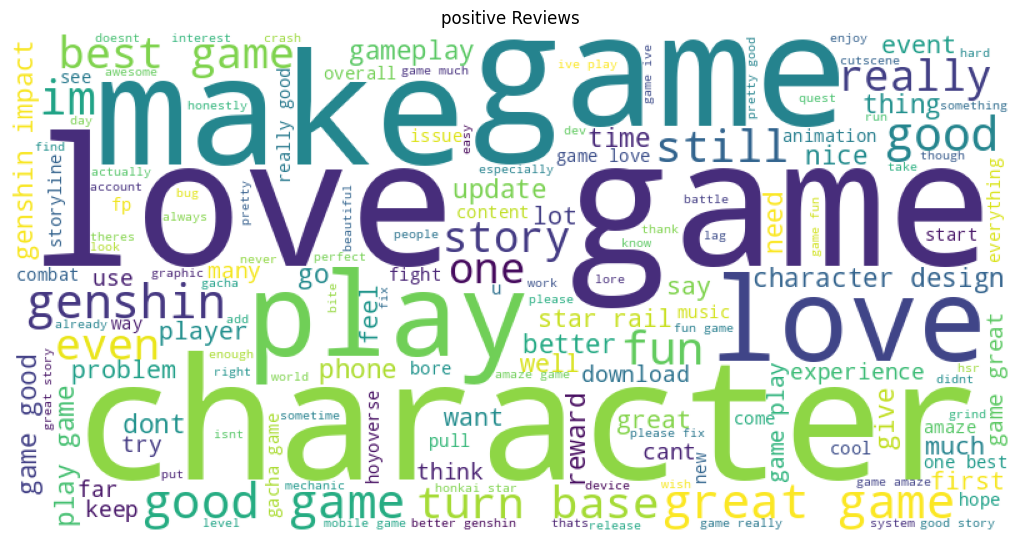

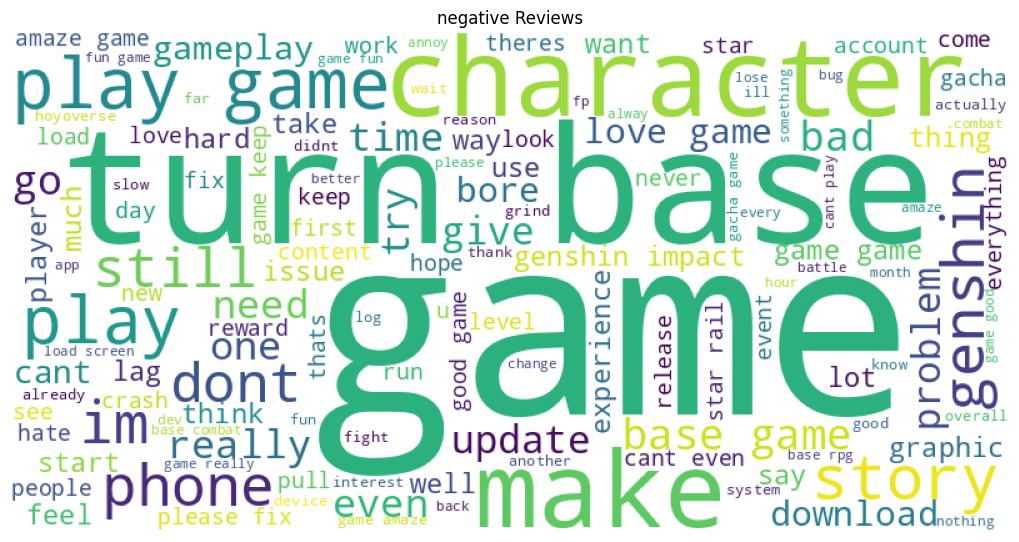

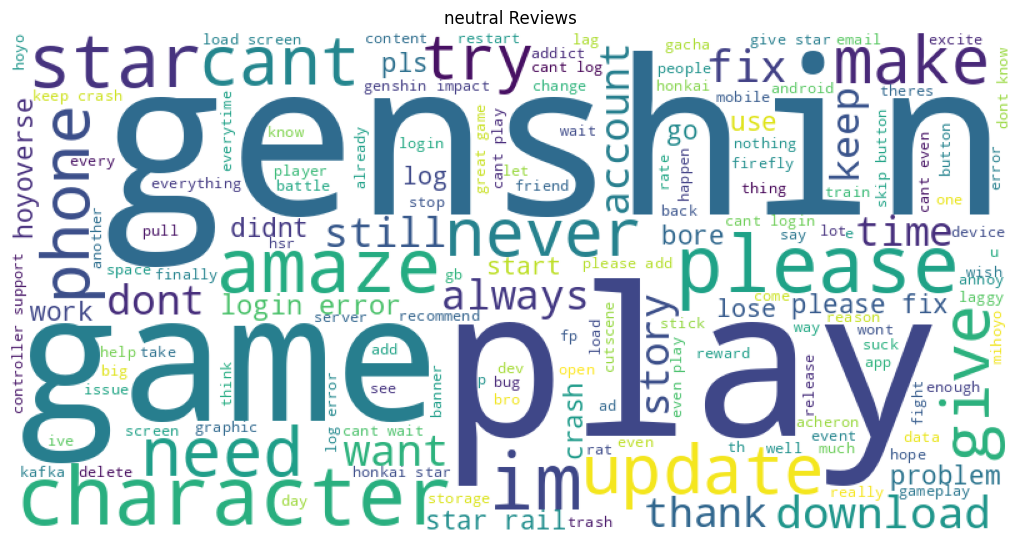

In [25]:
# Word Cloud of each sentiment
from wordcloud import WordCloud

def plot_wordcloud(sentiment):
    text = ' '.join(clean_df[clean_df['sentiment_label'] == sentiment]['cleaned_content'])
    wordcloud = WordCloud(width = 800, height = 400, 
                background_color ='white', 
                # stopwords = set(stopwords.words('english')), 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (10, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(f'{sentiment} Reviews')
    plt.show()
    
plot_wordcloud('positive')
plot_wordcloud('negative')
plot_wordcloud('neutral')

# Schema 1 : TF-IDF with Random Forest Training

## Feature Extraction

In [50]:
# Insert the data to train the model
X = clean_df['cleaned_content']
y = clean_df['sentiment_label']
 
# Feature extraction
tfidf = TfidfVectorizer(max_features=900, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)
 
# Convert feature extraction result to dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
 
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), y, test_size=0.2, random_state=42)

# Show the feature extraction
features_df

,able,absolute,absolutely,account,acheron,act,action,actual,actually,ad,...,yall,yeah,year,years,yes,yet,youll,youre,yuan,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

In [51]:
from sklearn.ensemble import RandomForestClassifier
 
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()
 
# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train, y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)
 
# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)
 
# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9972511378486774
Random Forest - accuracy_test: 0.8754506128334535


# Schema 2 : TF-IDF with Logistic Regression

## Feature Extraction

In [55]:
# Insert the data to train the model
X = clean_df['cleaned_content']
y = clean_df['sentiment_label']
 
# Feature extraction
tfidf = TfidfVectorizer(max_features=900, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)
 
# Convert feature extraction result to dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
 
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), y, test_size=0.2, random_state=42)

# Show the feature extraction
features_df

,able,absolute,absolutely,account,acheron,act,action,actual,actually,ad,...,yall,yeah,year,years,yes,yet,youll,youre,yuan,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

In [56]:
from sklearn.linear_model import LogisticRegression
 
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()
 
# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train, y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train)
y_pred_test_lr = logistic_regression.predict(X_test)
 
# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)
 
# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)
 
# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9390293362173854
Logistic Regression - accuracy_test: 0.9224945926459985


# Schema 3: Bag of Words with Random Forest

## Feature Extraction

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=500, min_df=17, max_df=0.8)
X_bow = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

## Modelling

In [31]:
from sklearn.ensemble import RandomForestClassifier
 
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()
 
# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)
 
# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())
 
# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)
 
# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9932855662205399
Random Forest - accuracy_test: 0.8734679163662581


# Schema 4 : TF-IDF with RNN

In [62]:
# Insert the data to train the model
X = clean_df['cleaned_content']
y = clean_df['sentiment_label']
 
# Feature extraction
tfidf = TfidfVectorizer(max_features=900, min_df=17, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)
 
# Convert feature extraction result to dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
 
# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), y, test_size=0.2, random_state=42)

# Show the feature extraction
features_df

,able,absolute,absolutely,account,acheron,act,action,actual,actually,ad,...,yall,yeah,year,years,yes,yet,youll,youre,yuan,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27734,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
import tensorflow as tf

rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=900, output_dim=64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

rnn_model.evaluate(X_test, y_test)

Epoch 1/10


2024-11-05 15:04:12.666520: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 79887600 exceeds 10% of free system memory.


621/694 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.5578 - loss: 0.9649

KeyboardInterrupt: 

In [64]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
